## ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) DSI-Project 3: Web API & Sub-Reddit Classification with NLP (Bitcoin vs. Dogecoin)

### Problem Statement 

Reddit is basically a large group of social news in which registered users can talk about almost anything you can imagine under "sub-reddit", a common place for people to share and discuss about any particular topic, from news, to pop culture, to technology, to comics, to any relationship advices, or to the weirdest things in the world. Since there are more than 138,000 active subreddits, users are able to interact with contents called "posts" (which are titled, contain a main body of either text or media attachments, etc.) through comments and participate in all of them freely except private subreddits, which will be requried an admission process.

As there are extremely large posts on reddit, it is near to impossible to sort all the posts manually. Consider the following scenario: What if a system error or basic human error causes sub-reddit tags to become distorted? Then the tedious responsibility of fixing it befalls someone to read, understand, and classify the posts. This makes it difficult to guess which sub-Reddit a given post belongs to just by staring at it.

This leads me to the problem: "How accurately can we use machine learning to classify similar content from two different sources?"

The aim of this project is to classify from 2 different subreddits, /r/Bitcoin and /r/dogecoin. I will scrape 1000 posts for each of the two sub-Reddits using Reddit’s API, clean our raw data by getting rid of irrelevant content, turn messy stuff of post-level data into a processable form, then train and test out 4 different classification models (Random Forest,Logistic Regression,  Naive Bayes Classifier, and Supporting Vector Machine ) which will be evaluated based on accuracy scores, as we are only concerned about whether or not a post is correctly classified since Bitcoin and Dogecoin are so many in common, investors or anyone interested in both can misunderstand and lead to investment mistakes in the future.

### Contents:
- [Data Collection](#Data-Collection)
    - [Import packages](#Import-Packages)
    - [Pulling Data](#Pulling-Data)
- [Data Cleaning & Exploratory Data Analysis](#Data-Cleaning-and-Exploratory-Data-Analysis-(EDA)
    -  [Remove duplicated data (name_id)](#Remove-duplicated-data-(name_id)
    -  [Fill NaN values with empty string for 'text', else the operation cannot be done](#Fill-NaN-values-with-empty-string-for-'text',-else-the-operation-cannot-be-done)
    -  [Combined Title and Text Data into a single column](#Combined-Title-and-Text-Data-into-a-single-column)
    -  [Extracts an element value from an XML string](#Extracts-an-element-value-from-an-XML-string)
    -  [Create reveiew_to_words function to clean the data](#Create-reveiew_to_words-function-to-clean-the-data)
    -  [Further Visualizations: Word Clouds](#Further-Visualizations:-Word-Clouds)
    -  [Binarizing Target Variable subreddit](#Binarizing-Target-Variable-subreddit)
    -  [Plot 2 horizontal bar charts of the top 20 features of each subreddit](#Plot-2-horizontal-bar-charts-of-the-top-20-features-of-each-subreddit)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
    -  [Determine Baseline Accuracy Score](#Determine-Baseline-Accuracy-Score)
    -  [Model 1: Random Forest](#Model-1:-Random-Forest)
    -  [Model 2: Logistic Regression](#Model-2:-Logistic-Regression)
    -  [Model 3: Multinomial Navie Bayes](#Model-3:-Multinomial-Navie-Bayes)
    -  [Model 4: Supporting Vector Machine](#Model-4:-Supporting-Vector-Machine)
    -  [Confusion Matrix](#Confusion-Matrix)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

#### Data Collection

##### Import Packages

In [2]:
# Load data collection libraries
import requests
import time
import pandas as pd
import random
import re

# Load text processing libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords # Import the stopword list
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn import svm

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
#from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Miscellaneous
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load proprocessing/modeling/evaluation libraries
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm_notebook as tqdm #show progress bar 

from bs4 import BeautifulSoup #Scrapping function

According to the limitation of Reddit's APIs, it can only be able to pull 25 requests at once. Therefore to improve efficientcy, I will loop these pulls in order to get the next consecutive requests.

#### Pulling Data

In [3]:
# Create Scrapping function to pull subreddit posts

def scrape_data(urls, num_req):
    
    posts = []
    
    # Get posts as list of dictionaries, each containing data on one post
    for url in tqdm(urls):                   # show progress bar
        after = None
        
        # Create a loop that does max 25 requests per pull
        for i in tqdm(range(num_req)):
            if after == None:
                params = {}                  # base case
            else:
                params = {'after': after}    # subsequent iterations
                
            #Set header to prevent 429 error       
            headers = {'User-agent': 'GA SG Bot 0.1'}
            
            res = requests.get(url, params=params, headers=headers)
            if res.status_code == 200:                                           
                the_json = res.json()                        # Pull JSON
                posts.extend(the_json['data']['children'])   # Get subreddit posts
                after = the_json['data']['after']            # 'after' = ID of the last post in this iteration
            else:
                print(res.status_code)
                break
            time.sleep(1)
    
    # Extract name id, title, text and subreddit origin from data and return in a DataFrame
    names, titles, texts, subreddits = [], [], [], []
    for i in range(len(posts)):
        names.append(posts[i]['data']['name'])
        titles.append(posts[i]['data']['title'])
        texts.append(posts[i]['data']['selftext'])
        subreddits.append(posts[i]['data']['subreddit'])
        
    return pd.DataFrame({'name': names, 'title': titles, 'text': texts, 'subreddit': subreddits})

The two subreddits we have chosen here are /r/Bitcoin/ and /r/Dodgecoin/

In [12]:
# Scrape Bitcoin and Dogecoin posts from subreddits
df = scrape_data([
    "https://www.reddit.com/r/dogecoin.json",
    "https://www.reddit.com/r/Bitcoin.json"
], num_req=40)

In order to keep the posts, I will save results from scrape as CSV

In [5]:
# Save results from scrape as csv
df.to_csv('./data/posts_draft.csv', index=False)

# Data Cleaning and Exploratory Data Analysis (EDA)

In [4]:
# Read from csv if not scraping
df = pd.read_csv('./data/posts_draft.csv')

In [5]:
# View first 5 rows
df.head()

,name,title,text,subreddit
0,t3_l87wcr,HOW TO BUY DOGECOIN,WARNING. Do NOT fall for hype. Don't think you...,dogecoin
1,t3_m8ddb5,DOGECOIN DAILY DISCUSSION - 19th March,"Hi Shibes,\n\nHere is another daily discussion...",dogecoin
2,t3_m85jwo,🔥,NaN,dogecoin
3,t3_m871d2,"HERES THE PLAN, NEW SHIBES",NaN,dogecoin
4,t3_m7rx99,Bringing back my most popular post. SO IMPORTA...,NaN,dogecoin


In [6]:
# View last 5 rows
df.tail()

,name,title,text,subreddit
1994,t3_m7vsh7,Which one of these app is the best?,I’m looking for which app is the best and all ...,Bitcoin
1995,t3_m7vq8i,BITCOIN/CRYPTO horror stories. I want to hear ...,I’ve always been a little paranoid about excha...,Bitcoin
1996,t3_m7visw,"Daily Bitcoin News March 17th, 2021",NaN,Bitcoin
1997,t3_m7qn4o,Portfolio app?,Anyone know of a good app that I can track dif...,Bitcoin
1998,t3_m7veyj,BoA creating FUD by appealing to the green mov...,NaN,Bitcoin


In [7]:
#View shape
df.shape

(1999, 4)

In [8]:
df['subreddit'].value_counts()

dogecoin    1003
Bitcoin      996
Name: subreddit, dtype: int64

In [9]:
df.isnull().sum()

name            0
title           0
text         1153
subreddit       0
dtype: int64

In [10]:
df['name'].value_counts()

t3_m8asha    2
t3_m7vwf6    2
t3_m8bs2s    2
t3_m7vd7v    2
t3_m86cnu    2
            ..
t3_m862i6    1
t3_m772b5    1
t3_m7d3vv    1
t3_m7vzd6    1
t3_m7vp5s    1
Name: name, Length: 1646, dtype: int64

#### Remove duplicated data (name_id)

Since there are some duplicated rows by comparing name ids, then I will drop them out!

In [11]:
# Drop duplicate rows by comparing name ids
df.drop_duplicates(subset='name', inplace=True)

In [12]:
#View shape
df.shape

(1646, 4)

In [13]:
# Check for nulls
df.isnull().sum()

name           0
title          0
text         961
subreddit      0
dtype: int64

In [14]:
# Examine rows with null texts
df[df['text'].isnull()]

,name,title,text,subreddit
2,t3_m85jwo,🔥,NaN,dogecoin
3,t3_m871d2,"HERES THE PLAN, NEW SHIBES",NaN,dogecoin
4,t3_m7rx99,Bringing back my most popular post. SO IMPORTA...,NaN,dogecoin
5,t3_m872tx,I’m not mad,NaN,dogecoin
6,t3_m84r36,The winner will get the Doge customers !! They...,NaN,dogecoin
...,...,...,...,...
1731,t3_m6iecy,BitMEX Founder Surrenders to U.S. Authorities,NaN,Bitcoin
1738,t3_m69tlv,"Imagine being this much of an ignorant, propag...",NaN,Bitcoin
1739,t3_m6r7j0,BITCOIN Funny Tempered Glass Phone Case For ip...,NaN,Bitcoin
1742,t3_m6eroj,"Jeff Booth, Author of The Price of Tomorrow on...",NaN,Bitcoin


#### Fill NaN values with empty string for 'text', else the operation cannot be done

In [15]:
# Replace null texts with empty string
df.text.fillna(value='', inplace=True)

In [16]:
df.isnull().sum()

name         0
title        0
text         0
subreddit    0
dtype: int64

In [17]:
df.dtypes

name         object
title        object
text         object
subreddit    object
dtype: object

All scraped posts already have texts and their titles are also complete and unique. We are going to keep these rows for modeling.

#### Combined Title and Text Data into a single column

In [18]:
# Put titles and texts into a single column.
df['text_feature'] = df['title'] + ' ' + df['text']

In [19]:
df.head()

,name,title,text,subreddit,text_feature
0,t3_l87wcr,HOW TO BUY DOGECOIN,WARNING. Do NOT fall for hype. Don't think you...,dogecoin,HOW TO BUY DOGECOIN WARNING. Do NOT fall for h...
1,t3_m8ddb5,DOGECOIN DAILY DISCUSSION - 19th March,"Hi Shibes,\n\nHere is another daily discussion...",dogecoin,DOGECOIN DAILY DISCUSSION - 19th March Hi Shib...
2,t3_m85jwo,🔥,,dogecoin,🔥
3,t3_m871d2,"HERES THE PLAN, NEW SHIBES",,dogecoin,"HERES THE PLAN, NEW SHIBES"
4,t3_m7rx99,Bringing back my most popular post. SO IMPORTA...,,dogecoin,Bringing back my most popular post. SO IMPORTA...


In [20]:
# # Save results from removing duplicate rows and fillna as csv
# df.to_csv('./data/posts_draft2.csv', index=False)

#### Extracts an element value from an XML string

In [21]:
# Convert &amp;, &gt; and &lt; XML character entity references back to &, > and <
from xml.sax.saxutils import unescape
df.text_feature = df.text_feature.apply(unescape)

In [22]:
df['text_feature']

0       HOW TO BUY DOGECOIN WARNING. Do NOT fall for h...
1       DOGECOIN DAILY DISCUSSION - 19th March Hi Shib...
2                                                      🔥 
3                             HERES THE PLAN, NEW SHIBES 
4       Bringing back my most popular post. SO IMPORTA...
                              ...                        
1744    What is the Fundamental Case for Bitcoin? I'm ...
1745    Bitcoin Convert Dalio Bearish on American Futu...
1746    The US federal government is considering a $4T...
1814    Investment Proposition You shouldn't just buy ...
1815    The rise of Bitcoin is inevitable.  We are in ...
Name: text_feature, Length: 1646, dtype: object

#### Create reveiew_to_words function to clean the data

In [23]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    remove_list = ['Bitcoin', 'dogecoin', 'DOGECOIN', 'BITCOIN', 'www', 'https', 'bitcoin', 'doge', 'Dogecoin']
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) #Keep only Alphabets
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    meaningful_words = [w for w in meaningful_words if w not in remove_list]
    
    # 6. Stemming
    #lemmatizer = WordNetLemmatizer()
    p_stemmer = PorterStemmer()
    #tokens_lem = [lemmatizer.lemmatize(w) for w in meaningful_words]
    stem_word = [p_stemmer.stem(w) for w in meaningful_words]
    new_word = ' '.join(stem_word)
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return new_word

In [24]:
#Get the number of reviews based on the dataframe size.
total_reviews = df.shape[0]
print(f'There are {total_reviews} reviews.')

There are 1646 reviews.


Call the review_to_words function in order to clean df['text_feature']

In [27]:
# Initialize an empty list to hold the clean reviews.
df_reviews = []

print("Cleaning and parsing the training set reviews...")

# Instantiate counter.
j = 0

# For every review in our training set...
for df_review in df['text_feature']:
    
    # Convert review to words, then append to clean_train_reviews.
    df_reviews.append(review_to_words(df_review))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 100 == 0:
        print(f'Review {j + 1} of {total_reviews}.')
    
    j += 1
print (f'Review {j} of {total_reviews}.')

Cleaning and parsing the training set reviews...
Review 100 of 1646.
Review 200 of 1646.
Review 300 of 1646.
Review 400 of 1646.
Review 500 of 1646.
Review 600 of 1646.
Review 700 of 1646.
Review 800 of 1646.
Review 900 of 1646.
Review 1000 of 1646.
Review 1100 of 1646.
Review 1200 of 1646.
Review 1300 of 1646.
Review 1400 of 1646.
Review 1500 of 1646.
Review 1600 of 1646.
Review 1646 of 1646.


In [28]:
df['reviews'] = df_reviews

In [30]:
df['reviews']

0       buy warn fall hype think go get instantli rich...
1       daili discuss th march hi shibe anoth daili di...
2                                                        
3                                     here plan new shibe
4                    bring back popular post import share
                              ...                        
1744    fundament case will persuad mean asshol ask qu...
1745    convert dalio bearish american futur free fina...
1746    us feder govern consid infrastructur bill mone...
1814    invest proposit buy know teach individu earn p...
1815    rise inevit midst chang time decentr blockchai...
Name: reviews, Length: 1646, dtype: object

#### Further Visualizations: Word Clouds

We can create some nice words clouds now that we've cleaned the data!

In [31]:
# Define function to draw word cloud
def draw_wordcloud(text, plot_title=None, mask_img=None):

    wordcloud = WordCloud(
        scale= 10,
        max_words=1000,
        background_color='white',
        colormap='brg',
        contour_width=3,
        contour_color='steelblue',
        random_state=42
    ).generate(text)
    
    plt.figure(figsize=(14,14), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    if plot_title:
        plt.title(plot_title, fontsize=20, pad=50)
    plt.axis("off")
    plt.show()

#### Word Colud Visualization - Bitcoin

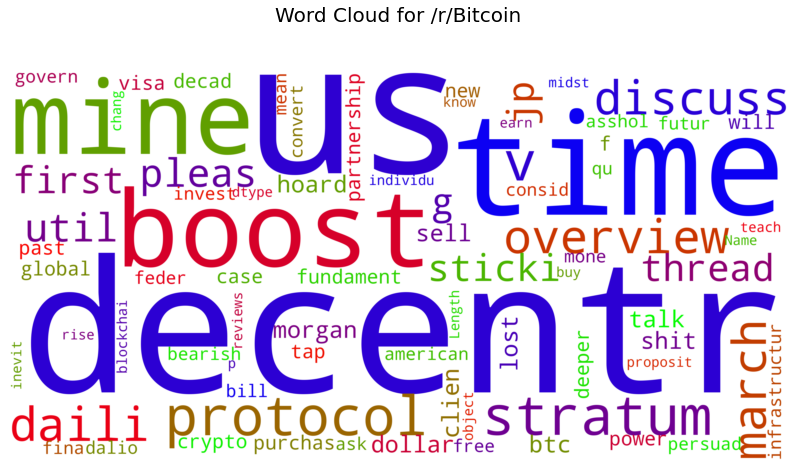

In [33]:
# Draw word cloud for /r/Bitcoin
draw_wordcloud( str(df[df.subreddit== 'Bitcoin'].reviews), 
               plot_title='Word Cloud for /r/Bitcoin')

#### Word Colud Visualization - Dogecoin

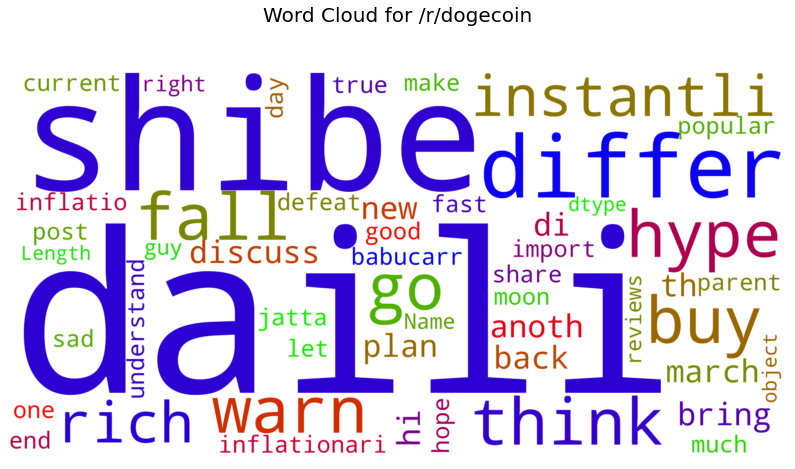

In [34]:
# Draw word cloud for /r/Dogecoin
draw_wordcloud( str(df[df.subreddit== 'dogecoin'].reviews), 
               plot_title='Word Cloud for /r/dogecoin')

Since we already removed some impact words such as 'Bitcoin', 'Dogecoin', etc.),in order to prevent misclassification, as both subreddits are very similar cryptocurrency issues and their words are commonly used across both subreddits.

Words that are more unique to the respective topics are:
* **decentr, boost, time, us** for Bitcoin
* **daili, shibe, warn, hype, differ** for Dogecoin

#### Plot 2 horizontal bar charts of the top 20 features of each subreddit

In [35]:
# Instantiate CountVectorizer and TfidfVectorizer
cvec = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

In [38]:
# Explore CountVectorizer token counts in /r/Bitcoin
words_cvec_pf = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='Bitcoin'].reviews).todense(),
                       columns=cvec.get_feature_names())
word_cvec_counts_pf = words_cvec_pf.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/Bitcoin
words_tfidf_pf = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='Bitcoin'].reviews).todense(),
                       columns=tfidf.get_feature_names())
word_counts_tfidf_pf = words_tfidf_pf.sum(axis=0)

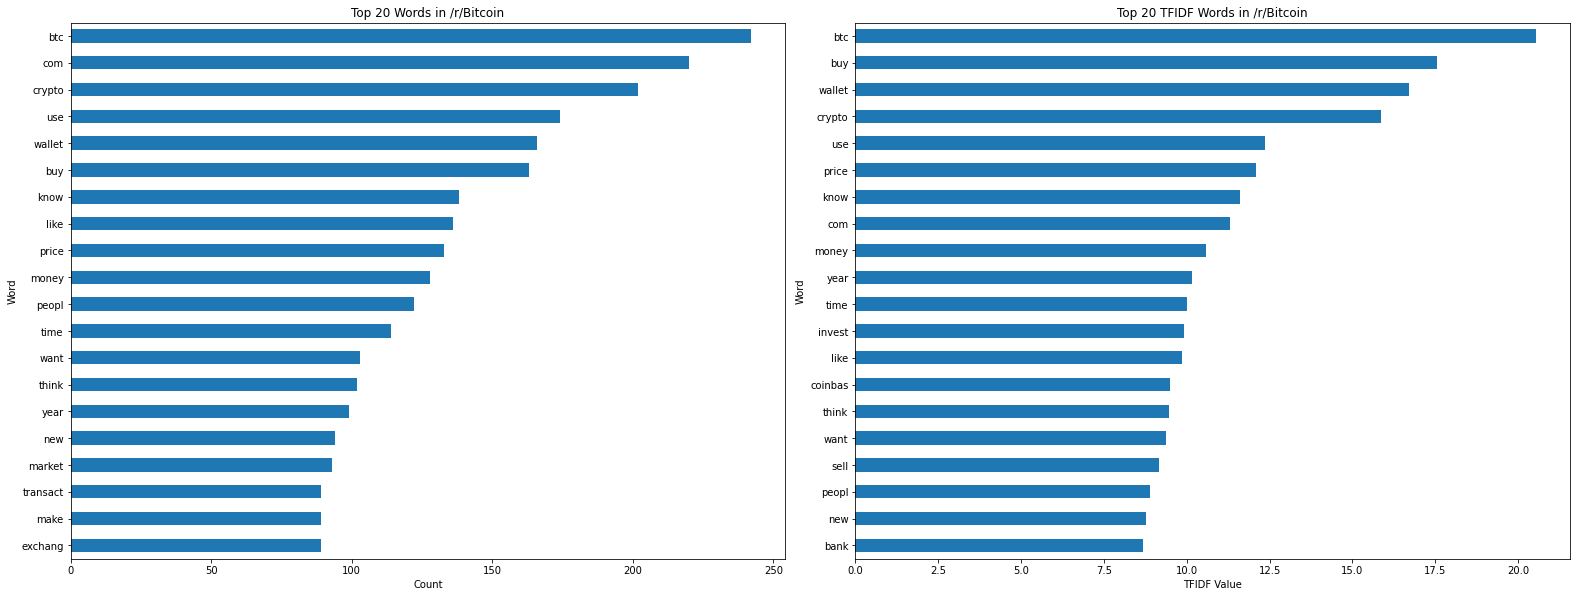

In [39]:
# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_cvec_counts_pf.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in /r/Bitcoin')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_pf.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in /r/Bitcoin')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

In [41]:
# Explore CountVectorizer token counts in /r/Bitcoin
words_cvec_pf = pd.DataFrame(cvec.fit_transform(df[df.subreddit=='dogecoin'].reviews).todense(),
                       columns=cvec.get_feature_names())
word_cvec_counts_pf = words_cvec_pf.sum(axis=0)

# Explore TfidfVectorizer token counts in /r/Bitcoin
words_tfidf_pf = pd.DataFrame(tfidf.fit_transform(df[df.subreddit=='dogecoin'].reviews).todense(),
                       columns=tfidf.get_feature_names())
word_counts_tfidf_pf = words_tfidf_pf.sum(axis=0)

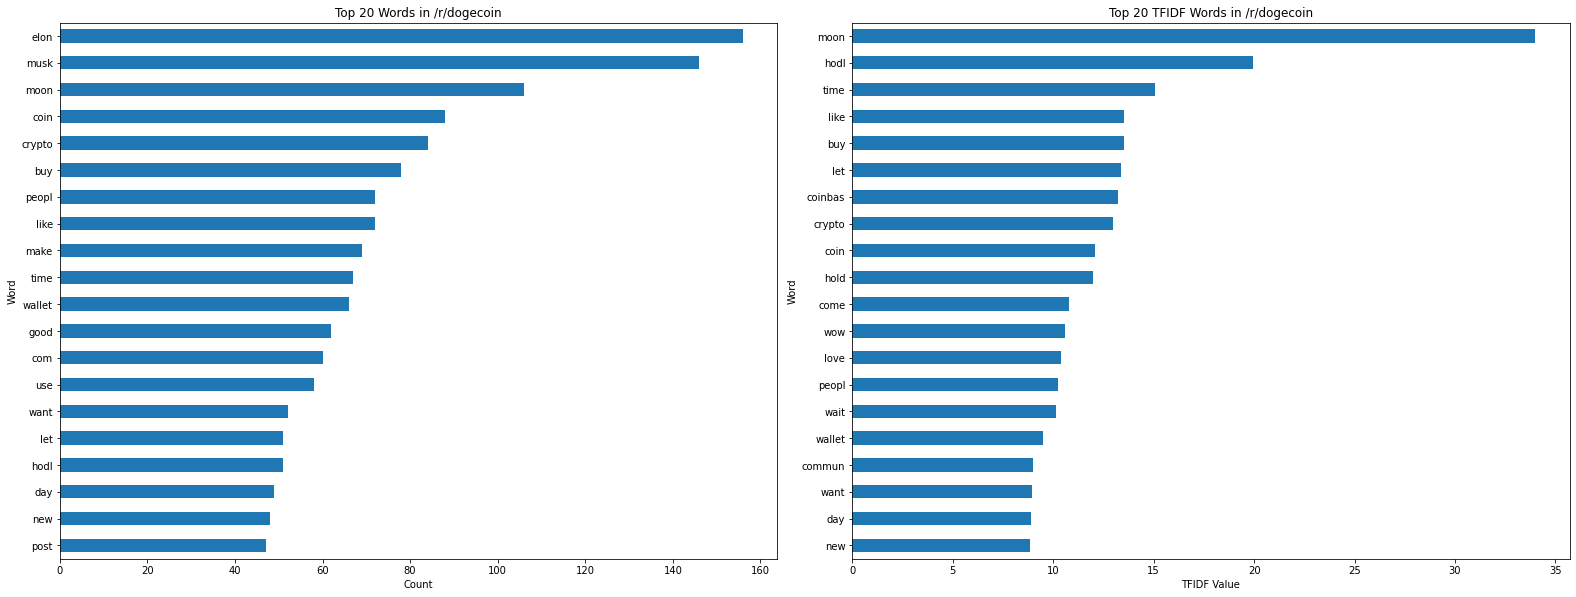

In [42]:
# Plot top 20 words
plt.figure(figsize=(22,16), facecolor='white')

plt.subplot(2,2,1)
word_cvec_counts_pf.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 Words in /r/dogecoin')
plt.xlabel('Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_counts_tfidf_pf.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TFIDF Words in /r/dogecoin')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

#### Binarizing Target Variable subreddit

In [43]:
# Engineer a feature to turn subreddit into a 1/0 column, where 1 indicates Bitcoin
df['subreddit'] = [1 if i == 'Bitcoin' else 0 for i in df.subreddit]

In [44]:
df.head()

,name,title,text,subreddit,text_feature,reviews
0,t3_l87wcr,HOW TO BUY DOGECOIN,WARNING. Do NOT fall for hype. Don't think you...,0,HOW TO BUY DOGECOIN WARNING. Do NOT fall for h...,buy warn fall hype think go get instantli rich...
1,t3_m8ddb5,DOGECOIN DAILY DISCUSSION - 19th March,"Hi Shibes,\n\nHere is another daily discussion...",0,DOGECOIN DAILY DISCUSSION - 19th March Hi Shib...,daili discuss th march hi shibe anoth daili di...
2,t3_m85jwo,🔥,,0,🔥,
3,t3_m871d2,"HERES THE PLAN, NEW SHIBES",,0,"HERES THE PLAN, NEW SHIBES",here plan new shibe
4,t3_m7rx99,Bringing back my most popular post. SO IMPORTA...,,0,Bringing back my most popular post. SO IMPORTA...,bring back popular post import share


In [46]:
df.tail()

,name,title,text,subreddit,text_feature,reviews
1744,t3_m6hozw,What is the Fundamental Case for Bitcoin?,I'm willing to be persuaded and I don't mean t...,1,What is the Fundamental Case for Bitcoin? I'm ...,fundament case will persuad mean asshol ask qu...
1745,t3_m6ems2,Bitcoin Convert Dalio Bearish on American Futu...,,1,Bitcoin Convert Dalio Bearish on American Futu...,convert dalio bearish american futur free fina...
1746,t3_m5y95i,The US federal government is considering a $4T...,Where does the money come from?,1,The US federal government is considering a $4T...,us feder govern consid infrastructur bill mone...
1814,t3_m8dfwl,Investment Proposition,You shouldn't just buy Bitcoin you should know...,1,Investment Proposition You shouldn't just buy ...,invest proposit buy know teach individu earn p...
1815,t3_m8dfwa,The rise of Bitcoin is inevitable.,"We are in the midst of changes in times, and ...",1,The rise of Bitcoin is inevitable. We are in ...,rise inevit midst chang time decentr blockchai...


In [47]:
df_reviews[:10]

['buy warn fall hype think go get instantli rich trust random peopl offer financi advic cryptocurr wild wild west invest mani peopl want take money run must educ good bad must understand someth rush said buy ago ask commun make post buy mani help thank choos one post time read follow one link pleas make sure give post love reddit gold would awesom anyth bad post send mod mail let know post edit bad inform gone buy easi step easi hour reddit com r comment l np buy easi step easi buy eezi step dumdum reddit com r comment l nxxp buy eezi step dumdum buy coin simpl wow reddit com r comment l nzb buy coin simpl wow purchas reddit com r comment l ok purchas beginn buy cryptocurr easi way get free money referr reddit com r comment l po q beginn buy cryptocurr easi buy today reddit com r comment l jfq buy today buy coin cheapest trade fee reddit com r comment l yrw buy coin cheapest buy simpl easi uk aust europ asia reddit com r comment lag ig buy simpl easi ukausteuropeasia moon bonu messag a

# Preprocessing and Modeling

We will be considering the following models to see which one of them produces a better score.

Model 1: Random Forest
- CountVectorizer with Random Forest
- TfidfVectorizer with Random Forest

Model 2: Logistic Regression
- CountVectorizer with Logistic Regression
- TfidfVectorizer with Logistic Regression

Model 3: Multinomial Naive Bayes 
- CountVectorizer with Multinomial Naive Bayes
- TfidfVectorizer with Multinomial Naive Bayes

Model 4: Supporting Vector Machine 
- CountVectorizer with Supporting Vector Machine
- TfidfVectorizer with Supporting Vector Machine

### Train/Test Split Data

In [48]:
# Split data into X and y
X = df['reviews']
y = df['subreddit']

In [49]:
X.shape

(1646,)

With all the data now cleaned, we can prepare for modeling by applying a 75-25 train-test split.

In [50]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y) # account for slight class unbalance

### Determine Baseline Accuracy Score

The Baseline Accuracy is the case when we predict the majority class for all observations.

The classification metric we will be using to measure the strength of our model is Accuracy since we’re only concerned about whether a post was categorized correctly or not. 

In [51]:
y.value_counts(normalize = True)

0    0.54678
1    0.45322
Name: subreddit, dtype: float64

At given any post, we would predict that it belongs to the Dogecoin (y = 0) subreddit everytime. Therefore, the baseline accuracy is 0.54678 or 54.68% which are the majority class then the baseline accuracy will be based off of.

### Modeling and Evaluation

We'll be running a few classification models so this function will help automate the fit and scoring process.

(Note that we've integrated word vectorization into the modeling process using Pipelines)

In [52]:
# Function to automate fit and reporting process
def eval_model(pipe, grid_params):
    
    # Perform Grid Search
    gs = GridSearchCV(pipe, grid_params, cv=5, scoring='accuracy', verbose = 1, n_jobs=1)
    results = gs.fit(X_train, y_train)

    # Get best params
    vectorizer_params = results.best_estimator_.steps[0][1].get_params()
    model_params = results.best_estimator_.steps[1][1].get_params()

    # Get score
    train_score = results.best_score_
    print('Best TRAIN accuracy: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST set accuracy: {:.4f}'.format(test_score))

    print("----------------------------------------")
    
    return results, train_score, test_score, vectorizer_params, model_params

### Model 1: Random Forest

In [53]:
%%time
# Define Pipeline
pipe_rf = Pipeline(steps=[('vectorizer', CountVectorizer()),
                       ('model', RandomForestClassifier())
                      ])

# Construct Grid Parameters
grid_params_rf = {"vectorizer__max_features": [2000, 3000, 4000],
                  "vectorizer__ngram_range":  [(1,1), (1,2)],
                  "vectorizer__stop_words":   ['english'],
                  "model__n_estimators":      [15, 20, 25],
                  "model__max_depth":         [15, 20, 25]
              }

# Run reporting function with pipe and grid
results_rf_cvec, train_score_rf, test_score_rf, tfdif_params_rf, rf_params = eval_model(pipe_rf, grid_params_rf)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}'
      .format(**tfdif_params_rf))
print('Optimal Model params: n_estimators={n_estimators}, max_depth={max_depth} '.format(**rf_params))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   56.6s finished


Best TRAIN accuracy: 0.7545
Best TEST set accuracy: 0.7427
----------------------------------------
Optimal Vectorizer params: max_features=2000, ngram_range=(1, 1)
Optimal Model params: n_estimators=25, max_depth=25 
Wall time: 56.9 s


In [54]:
%%time
# Define Pipeline
pipe_rf = Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                       ('model', RandomForestClassifier())
                      ])

# Construct Grid Parameters
grid_params_rf = {"vectorizer__max_features": [2000, 3000, 4000],
                  "vectorizer__ngram_range":  [(1,1), (1,2)],
                  "vectorizer__norm":         ['l1', 'l2'],
                  "vectorizer__stop_words":   ['english'],
                  "model__n_estimators":      [15, 20, 25],
                  "model__max_depth":         [15, 20, 25],
                  "model__min_samples_leaf":  [1],
                  "model__criterion":         ['gini'],
                  "model__random_state":      [42]
              }

# Run reporting function with pipe and grid
results_rf_tfidf, train_score_rf, test_score_rf, tfdif_params_rf, rf_params = eval_model(pipe_rf, grid_params_rf)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}, norm={norm} '
      .format(**tfdif_params_rf))
print('Optimal Model params: n_estimators={n_estimators}, max_depth={max_depth} '.format(**rf_params))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.0min finished


Best TRAIN accuracy: 0.7537
Best TEST set accuracy: 0.7451
----------------------------------------
Optimal Vectorizer params: max_features=3000, ngram_range=(1, 1), norm=l2 
Optimal Model params: n_estimators=25, max_depth=25 
Wall time: 1min 59s


#### Key insighs - Random Forest Model with TfidfVectorizer:
- The performance under Random Forest classifier give an accuracy score of 75%, which higher than the baseline score by more than 1.4x.
- Seeing how close the training and testing accuracy scores are to each other suggests that our model's performance is consistent when applied to unseen data.
- There seem to be a bit overfitting here since the training set's accuracy score is 0.86% higher than the test set's.

### Model 2: Logistic Regression

In [55]:
%%time
# Define Pipeline
pipe_logit = Pipeline(steps=[('vectorizer', CountVectorizer()),
                          ('model', LogisticRegression())
                         ])

# Construct Grid Parameters
grid_params_logit = {"vectorizer__max_features": [2500, 3000, 3500],
                     "vectorizer__ngram_range":  [(1,1), (1,2)],
                     "vectorizer__stop_words":   ['english'],
                     "model__penalty":           ['l1', 'l2'],
                     "model__C":                 [3.0, 10.0, 100.0],
                     "model__tol":               [0.001],
                     "model__random_state":      [42]      
              }

# Run reporting function with pipe and grid
results_logit_cvec, train_score_logit, test_score_logit, tfdif_params_logit, logit_params = eval_model(pipe_logit, grid_params_logit)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}'
      .format(**tfdif_params_logit))
print('Optimal Model params: penalty={penalty}, C={C} '.format(**logit_params))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   28.2s finished


Best TRAIN accuracy: 0.7950
Best TEST set accuracy: 0.7985
----------------------------------------
Optimal Vectorizer params: max_features=3000, ngram_range=(1, 2)
Optimal Model params: penalty=l2, C=3.0 
Wall time: 28.6 s


In [56]:
%%time
# Define Pipeline
pipe_logit = Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                          ('model', LogisticRegression())
                         ])

# Construct Grid Parameters
grid_params_logit = {"vectorizer__max_features": [2500, 3000, 3500],
                     "vectorizer__ngram_range":  [(1,1), (1,2)],
                     "vectorizer__norm":         ['l1', 'l2'],
                     "vectorizer__stop_words":   ['english'],
                     "model__penalty":           ['l1', 'l2'],
                     "model__C":                 [3.0, 10.0, 100.0],
                     "model__tol":               [0.001],
                     "model__random_state":      [42]      
              }

# Run reporting function with pipe and grid
results_logit_tfidf, train_score_logit, test_score_logit, tfdif_params_logit, logit_params = eval_model(pipe_logit, grid_params_logit)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}, norm={norm} '
      .format(**tfdif_params_logit))
print('Optimal Model params: penalty={penalty}, C={C} '.format(**logit_params))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   53.6s finished


Best TRAIN accuracy: 0.8063
Best TEST set accuracy: 0.7937
----------------------------------------
Optimal Vectorizer params: max_features=2500, ngram_range=(1, 2), norm=l2 
Optimal Model params: penalty=l2, C=3.0 
Wall time: 53.9 s


#### Key insighs - Logistic Regression with CountVectorizer:
- The Logistic Regression did better than the Random Forest Classifier since both Training and Testing accuracy scores were higher.
- However, the testing set's accuracy score is lower than the training set's which may suggest a very small degree of overfitting.

### Model 3: Multinomial Navie Bayes

In [57]:
%%time
# Define Pipeline
pipe_mnb = Pipeline(steps=[('vectorizer', CountVectorizer()),
                          ('model',  MultinomialNB())
                         ])

# Construct Grid Parameters
grid_params_mnb = {"vectorizer__max_features": [2500, 3000, 3500],
                     "vectorizer__ngram_range":  [(1,1), (1,2)],
                     "vectorizer__stop_words":   ['english'],
                    }

# Run reporting function with pipe and grid
results_mnb_cvec, train_score_mnb, test_score_mnb, tfdif_params_mnb, mnb_params = eval_model(pipe_mnb, grid_params_mnb)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}'
      .format(**tfdif_params_mnb))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best TRAIN accuracy: 0.8120
Best TEST set accuracy: 0.8034
----------------------------------------
Optimal Vectorizer params: max_features=3500, ngram_range=(1, 1)
Wall time: 3.23 s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.0s finished


In [58]:
%%time
# Define Pipeline
pipe_mnb = Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                          ('model',  MultinomialNB())
                         ])

# Construct Grid Parameters
grid_params_mnb = {"vectorizer__max_features": [2500, 3000, 3500],
                     "vectorizer__ngram_range":  [(1,1), (1,2)],
                     "vectorizer__norm":         ['l1', 'l2'],
                     "vectorizer__stop_words":   ['english'],
                     "model__alpha":             [0, 0.25, 0.5, 0.75, 1]  
              }

# Run reporting function with pipe and grid
results_mnb_tfidf, train_score_mnb, test_score_mnb, tfdif_params_mnb, mnb_params = eval_model(pipe_mnb, grid_params_mnb)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}, norm={norm} '
      .format(**tfdif_params_mnb))
print('Optimal Model params: alpha={alpha} '.format(**mnb_params))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   32.4s finished


Best TRAIN accuracy: 0.8071
Best TEST set accuracy: 0.7961
----------------------------------------
Optimal Vectorizer params: max_features=3000, ngram_range=(1, 2), norm=l2 
Optimal Model params: alpha=0.25 
Wall time: 32.7 s


#### Key insighs - Multinomial Naive Bayes with CountVectorizer:
- Naive Bayes gives the highest testing accuracy (80.34%) out of all four models, eventhough the training set (81.20%) performed slightly better than the Logistic Regression (80.63%)
- Again haveing a bit overfitting evident here since the train accuracy score is actually 0.86 higher than the testing score, which again shows consistency.

#### Model 4: Supporting Vector Machine

In [59]:
%%time
# Define Pipeline
pipe_svm = Pipeline(steps=[('vectorizer', CountVectorizer()),
                          ('model', svm.SVC())
                         ])

# Construct Grid Parameters
grid_params_svm = {"vectorizer__max_features":   [2000, 3000, 4000],
                     "vectorizer__ngram_range":  [(1,1),(1,2)],
                     "vectorizer__stop_words":   ['english'],
                  }

# Run reporting function with pipe and grid
results_svm_cvec, train_score_svm, test_score_svm, tfdif_params_svm, svm_params = eval_model(pipe_svm, grid_params_svm)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}'
      .format(**tfdif_params_svm))
print('Optimal Model params: C={C}, kernel={kernel}, gamma={gamma} '.format(**svm_params))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.2s finished


Best TRAIN accuracy: 0.7480
Best TEST set accuracy: 0.7379
----------------------------------------
Optimal Vectorizer params: max_features=2000, ngram_range=(1, 1)
Optimal Model params: C=1.0, kernel=rbf, gamma=scale 
Wall time: 7.61 s


In [60]:
%%time
# Define Pipeline
pipe_svm = Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                          ('model', svm.SVC())
                         ])

# Construct Grid Parameters
grid_params_svm = {"vectorizer__max_features":   [2000, 3000, 4000],
                     "vectorizer__ngram_range":  [(1,1),(1,2)],
                     "vectorizer__norm":         ['l1'],
                     "vectorizer__stop_words":   ['english'],
                     "model__C":                 [1.0, 10.0, 100.0],
                     "model__kernel":            ['rbf', 'linear'],
                     "model__gamma":             ['auto', 0.0001, 0.001] 
                  }

# Run reporting function with pipe and grid
results_svm_tfidf, train_score_svm, test_score_svm, tfdif_params_svm, svm_params = eval_model(pipe_svm, grid_params_svm)

print('Optimal Vectorizer params: max_features={max_features}, ngram_range={ngram_range}, norm={norm} '
      .format(**tfdif_params_svm))
print('Optimal Model params: C={C}, kernel={kernel}, gamma={gamma} '.format(**svm_params))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.4min finished


Best TRAIN accuracy: 0.7723
Best TEST set accuracy: 0.7743
----------------------------------------
Optimal Vectorizer params: max_features=4000, ngram_range=(1, 1), norm=l1 
Optimal Model params: C=100.0, kernel=linear, gamma=auto 
Wall time: 2min 24s


#### Key insighs - Supporting Vector Machine with TfidfVectorizer:
- The SVM gives a better score compared with Random Forest but also worse than two left models
- It seems that no overfitting is evident here since the test accuracy score is actually 0.20% higher than the training score, which again shows consistency.

We see that the following 2 models produce similarly good results.
- using **Multinomial Naive Bayes with CountVectorizer** : Best TEST set accuracy is: **80.34%**
- using **Logistic Regression with CountVectorizer** : Best TEST set accuracy is **79.85%**

#### Confusion Matrix 

In [61]:
# Function to compute confusion matrix
def conf_matrix(model_results, X_test, y_test):
    y_hat    = model_results.predict(X_test)  # get predictions
    cm = confusion_matrix(y_test, y_hat)      # get confusion matrix data
    tn, fp, fn, tp = cm.ravel()               # extract elements of confusion matrix
    
    # Convert Confusion Matrix to DataFrame
    cm_df = pd.DataFrame(cm,
                         columns = ['Predict Dogecoin (y=0)','Predict Bitcoin (y=1)'],
                         index = ['Actual Dogecoin (y=0)', 'Actual Bitcoin (y=1)'])
    return cm_df

In [62]:
# Function to compute all classification metrics
def eval_metric(confusion):
    sensitivity = confusion.loc['Actual Bitcoin (y=1)','Predict Bitcoin (y=1)']/sum(confusion.loc['Actual Bitcoin (y=1)',])
    specificity = confusion.loc['Actual Dogecoin (y=0)','Predict Dogecoin (y=0)']/sum(confusion.loc['Actual Dogecoin (y=0)',])
    accuracy = (confusion.loc['Actual Bitcoin (y=1)','Predict Bitcoin (y=1)'] 
                + confusion.loc['Actual Dogecoin (y=0)','Predict Dogecoin (y=0)'])/confusion.values.sum()
    precision = confusion.loc['Actual Bitcoin (y=1)','Predict Bitcoin (y=1)']/sum(confusion['Predict Bitcoin (y=1)'])
    return {"accuracy": np.round(accuracy,4),
            "sensitivity": np.round(sensitivity,4),
            "specificity": np.round(specificity,4),
            "precision": np.round(precision,4)}

In [63]:
# Random Forest
rf_cf = conf_matrix(results_rf_tfidf, X_test, y_test)
print(eval_metric(rf_cf))
rf_cf

{'accuracy': 0.7451, 'sensitivity': 0.5455, 'specificity': 0.9111, 'precision': 0.8361}


,Predict Dogecoin (y=0),Predict Bitcoin (y=1)
Actual Dogecoin (y=0),205,20
Actual Bitcoin (y=1),85,102


So out of the 412 testing posts, we see 205+102 = **307 posts were correctly classified**, while 20+85= **105 posts were misclassified** under Random Forest.

In [64]:
# Logistic Regression
logit_cf = conf_matrix(results_logit_cvec, X_test, y_test)
print(eval_metric(logit_cf))
logit_cf

{'accuracy': 0.7985, 'sensitivity': 0.6684, 'specificity': 0.9067, 'precision': 0.8562}


,Predict Dogecoin (y=0),Predict Bitcoin (y=1)
Actual Dogecoin (y=0),204,21
Actual Bitcoin (y=1),62,125


So out of the 412 testing posts, we see 204+125 = **329 posts were correctly classified**, while 62+21= **3 posts were misclassified** under the Logistic Regression.

In [65]:
# Multinomial Naive Bayes
mnb_cf = conf_matrix(results_mnb_cvec, X_test, y_test)
print(eval_metric(mnb_cf))
mnb_cf

{'accuracy': 0.8034, 'sensitivity': 0.7861, 'specificity': 0.8178, 'precision': 0.7819}


,Predict Dogecoin (y=0),Predict Bitcoin (y=1)
Actual Dogecoin (y=0),184,41
Actual Bitcoin (y=1),40,147


So out of the 412 testing posts, we see 184+147 = **331 posts were correctly classified**, while 40+41= **81 posts were misclassified** under the multinomial Naive Bayes

In [66]:
# Supporting Vector Machine
svm_cf = conf_matrix(results_svm_tfidf, X_test, y_test)
print(eval_metric(svm_cf))
svm_cf

{'accuracy': 0.7743, 'sensitivity': 0.8182, 'specificity': 0.7378, 'precision': 0.7217}


,Predict Dogecoin (y=0),Predict Bitcoin (y=1)
Actual Dogecoin (y=0),166,59
Actual Bitcoin (y=1),34,153


So out of the 412 testing posts, we see 166+153 = **319 posts were correctly classified**, while 34+59= **93 posts were misclassified** under the Supporting Vector Machine

# Conclusion and Recommendation

### Models Train/Test Score Comparison Table

| Models | CVEC(Train score) | CVEC(Test score) | Diff(%) | Tfidf (Train score) | Tfidf(Test score) | Diff(%) |
| --- | --- | --- | --- | --- |--- | --- |
| Baseline | 54.68% | 54.68% | - | 54.68% | 54.68% | - |
| Random Forest |75.45% | 74.27% | 1.18% | 75.37% | 74.51% | 0.86% |
| Logistic Regreesion | 79.50% | **79.85%** | **0.35%** | 80.63% | 79.37% | 1.26% |
| Naive Bayes | 81.20% | **80.34%** | **0.86%** | 80.71% | 79.61% | 1.1% |
| Supporting Vector Machine | 74.80% | 73.79% | 1.01% | 77.23%| 77.43% | 0.20% |

### Classification Matrix Table

| Evaluation Metrics | Model 1: Random Forest | Model 2: Logistic Regression | Model 3: Navie Bayes |Model 4: Supporting Vector Machine |
| --- | --- | --- | --- | --- |
| Accuracy | 74.51% | **79.85%** | **80.34%** | 77.43% | 
| Sensitivity | 54.55% | 66.84% | 78.61% | 81.82% | 
| Specificity | 91.11% | 90.67% | 81.78% | 73.78% | 
| Precision | 83.61% | 85.62% | 78.19% | 72.17% | 

All four models (Random Forest, Logistic Regression, Naive Bayes, and Support Vector Machine) exceed the baseline accuracy of 54.68% by at least 1.3x as almost models performed with an accuracy greater than 75% except Random Forest, demonstrating strong ability to classify at least 3 in 4 posts into the correct subreddit. However, the winner was definitely **the Multinomial Naive Bayes model, which was able to correctly 4 in 5 posts or 80.34%**. This is within expectation because the topics of two chosen subreddits are quite similar. 

Therefore, this is the model we would recommend Reddit Data Team to implement to help them classify error/buggy posts that have lost their subreddit tags and also help users, investors or anyone who interested in both subreddits preventing misunderstand and to not make investment mistakes in cryptocurrency trading in the future.

Further improvements for the model include:

- Collecting more training data not only just Text data but also Pic posted in a post as a feature to classify subreddits.
- Enhancing the model's ability to classify more than two subreddits in our classification model. 
- Tuning of parameters for any models to get a better score. However, this requires a longer amount of time to tune to get the perfect parameters.